# Sort candidate pulse sequences

From the job output, keep only the lines that contain the text "candidate pulse sequence" (can do `cat rl_pulse... | grep "candidate pulse sequence"`) or use regex to delete all lines that don't contain candidate sequences via `^((?!candidate pulse sequence).)*$`.

In [111]:
import sys
import os
import re
import pandas as pd
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import multiprocessing as mp
import importlib

In [25]:
sys.path.append('..')

In [26]:
import pulse_sequences as ps

In [112]:
# importlib.reload(ps)

<module 'pulse_sequences' from '../pulse_sequences.py'>

In [186]:
path = '../../data/2021-02/20210223-225947/'

In [187]:
candidates = []
with open(os.path.join(path, 'candidates.txt')) as file:
    for line in file:
        candidates.append(line)

In [188]:
c2 = []
for c in candidates:
    try:
        m = re.search(r'(.*?) candidate pulse sequence from \d+ \((.*?), array\((.*?)\), (.*?)\)\n', c)
        c2.append({
            'timestamp': m.group(1),
            'sequence': m.group(2),
            'last_pulse': m.group(3),
            'value': float(m.group(4))
        })
    except Exception as e:
        print('exception caught')
        # print(c)

exception caught


In [189]:
len(c2)

9832

In [190]:
df = pd.DataFrame(c2)

array([[<AxesSubplot:title={'center':'value'}>]], dtype=object)

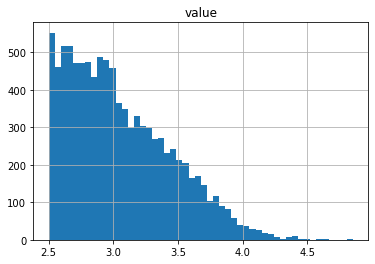

In [191]:
df.hist('value', bins=50)

In [192]:
df.sort_values('value', ascending=False, inplace=True)
# df

In [193]:
df['sequence'] = df['sequence'].apply(lambda x: [int(i) for i in x[1:-1].split(',')])

In [194]:
df['last_pulse'] = df['last_pulse'].apply(lambda x: [float(i) for i in x[1:-1].split(',')])

In [195]:
df['last_pulse'] = df['last_pulse'].apply(lambda x: np.argwhere(x)[0][0])

In [196]:
df['full_sequence'] = df['sequence'] + df['last_pulse'].apply(lambda x: [x])

In [197]:
df.head()

,timestamp,sequence,last_pulse,value,full_sequence
161,2021-02-23 23:27:07.875899,"[4, 2, 2, 4, 0, 4, 2, 4, 0, 0, 0, 4, 4, 2, 1, ...",3,4.851255,"[4, 2, 2, 4, 0, 4, 2, 4, 0, 0, 0, 4, 4, 2, 1, ..."
7856,2021-02-24 18:22:50.305398,"[4, 2, 1, 4, 0, 4, 1, 4, 1, 0, 4, 2, 3, 2, 3, ...",2,4.649613,"[4, 2, 1, 4, 0, 4, 1, 4, 1, 0, 4, 2, 3, 2, 3, ..."
9750,2021-02-24 22:48:40.699785,"[4, 2, 1, 1, 2, 2, 1, 0, 0, 4, 2, 3, 1, 0, 2, ...",0,4.640602,"[4, 2, 1, 1, 2, 2, 1, 0, 0, 4, 2, 3, 1, 0, 2, ..."
5469,2021-02-24 12:52:54.424929,"[4, 2, 1, 1, 2, 1, 2, 0, 4, 4, 0, 3, 0, 3, 2, ...",0,4.630758,"[4, 2, 1, 1, 2, 1, 2, 0, 4, 4, 0, 3, 0, 3, 2, ..."
4992,2021-02-24 11:44:24.873706,"[4, 2, 1, 1, 2, 4, 2, 4, 2, 0, 4, 1, 4, 1, 1, ...",0,4.606548,"[4, 2, 1, 1, 2, 4, 2, 4, 2, 0, 4, 1, 4, 1, 1, ..."


In [201]:
df.to_csv(os.path.join(path, 'candidates_sorted.csv'))

## Set up spin system

In [202]:
dipolar_strength = 1e2
pulse_width = 1e-5  # time is relative to chemical shift strength
delay = 1e-4
rot_error = 1e-2
N = 3  # number of spins
ensemble_size = 50

In [203]:
X, Y, Z = ps.get_collective_spin(N)

In [204]:
Hsys_ensemble = []
for _ in range(ensemble_size):
    Hsys_ensemble.append(ps.get_Hsys(N=N, dipolar_strength=dipolar_strength))
pulses_ensemble = []
for H in Hsys_ensemble:
    rot = np.random.normal(scale=rot_error)
    pulses_ensemble.append(ps.get_pulses(
        H, X, Y, Z, pulse_width=pulse_width, delay=delay, rot_error=rot
    ))

In [205]:
Utarget = qt.identity(Hsys_ensemble[0].dims[0])

## Check candidates

In [254]:
# read from file if not loaded above
# df = pd.read_csv('../../data/2021-02/20210219-082529/candidates_sorted.csv')

In [207]:
unique_sequences = df['full_sequence'].map(lambda x: tuple(x)).unique()

In [211]:
unique_sequences = [list(i) for i in unique_sequences]

In [214]:
len(unique_sequences)

9821

In [228]:
N_seq = 100
fidelities = np.zeros(N_seq)
with mp.Pool(4) as p:
    fidelities = p.starmap(ps.get_mean_fidelity,
                           [(c, Utarget, pulses_ensemble)
                            for c in df['full_sequence'].iloc[:N_seq]])
fidelities = np.array(fidelities)

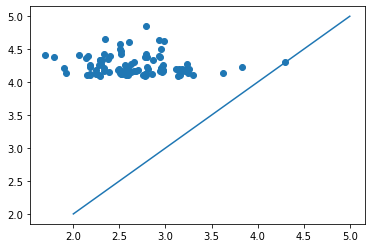

In [229]:
# confirm that calculated rewards match what was calculated from the job
plt.scatter(-np.log10(1 - fidelities), df['value'].iloc[:100])
plt.plot([2, 5], [2, 5])

In [219]:
np.argmin(1 - fidelities), (1 - fidelities).min(), -np.log10((1 - fidelities).min())

(28, 5.0241473022794025e-05, 4.29893763606439)

In [221]:
print(df['full_sequence'].iloc[28])

[4, 2, 1, 1, 2, 1, 2, 0, 4, 0, 3, 1, 3, 2, 3, 0, 0, 2, 4, 4, 2, 1, 2, 2, 2, 4, 0, 0, 2, 3, 4, 3, 4, 0, 1, 4, 3, 1, 3, 4, 0, 0, 4, 0, 2, 0, 0, 4]


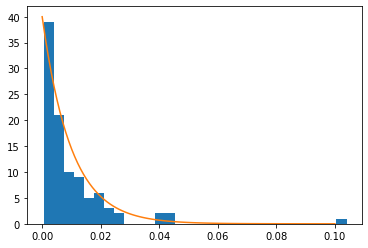

In [231]:
plt.hist(1 - fidelities, bins=30)
# fit exponential curve
X = np.linspace(0, .1, 100)
Y = np.exp(-1 / np.mean(1 - fidelities) * X)
plt.plot(X, Y * 40)

## Format and print pulse sequence

In [264]:
names = [
    r'\tau_{\pi/2}, \tau',
    r'X, \tau',
    r'-X, \tau',
    r'Y, \tau',
    r'-Y, \tau',
]

In [268]:
sequence_string = [names[i] for i in df['full_sequence'][23]]

print('$', ', '.join(sequence_string[:12]), '$')
print('$', ', '.join(sequence_string[12:24]), '$')
print('$', ', '.join(sequence_string[24:36]), '$')
print('$', ', '.join(sequence_string[36:48]), '$')

$ -X, \tau, Y, \tau, Y, \tau, Y, \tau, Y, \tau, -X, \tau, Y, \tau, -X, \tau, -Y, \tau, -X, \tau, -Y, \tau, X, \tau $
$ -X, \tau, Y, \tau, Y, \tau, Y, \tau, \tau_{\pi/2}, \tau, Y, \tau, \tau_{\pi/2}, \tau, -X, \tau, Y, \tau, -X, \tau, -X, \tau, -X, \tau $
$ Y, \tau, -X, \tau, \tau_{\pi/2}, \tau, -Y, \tau, -X, \tau, -X, \tau, -X, \tau, \tau_{\pi/2}, \tau, -Y, \tau, -Y, \tau, Y, \tau, X, \tau $
$ Y, \tau, -Y, \tau, -Y, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, -X, \tau, -X, \tau, -X, \tau, \tau_{\pi/2}, \tau, Y, \tau, -X, \tau $


Pulse sequence 23:

$ -X, \tau, Y, \tau, Y, \tau, Y, \tau, Y, \tau, -X, \tau, Y, \tau, -X, \tau, -Y, \tau, -X, \tau, -Y, \tau, X, \tau $
$ -X, \tau, Y, \tau, Y, \tau, Y, \tau, \tau_{\pi/2}, \tau, Y, \tau, \tau_{\pi/2}, \tau, -X, \tau, Y, \tau, -X, \tau, -X, \tau, -X, \tau $
$ Y, \tau, -X, \tau, \tau_{\pi/2}, \tau, -Y, \tau, -X, \tau, -X, \tau, -X, \tau, \tau_{\pi/2}, \tau, -Y, \tau, -Y, \tau, Y, \tau, X, \tau $
$ Y, \tau, -Y, \tau, -Y, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, \tau_{\pi/2}, \tau, -X, \tau, -X, \tau, -X, \tau, \tau_{\pi/2}, \tau, Y, \tau, -X, \tau $